# What is it?

I have read a great article ["Why ex-post power using estimated effect sizes is bad, but an ex-post MDE is not?"](https://blogs.worldbank.org/impactevaluations/why-ex-post-power-using-estimated-effect-sizes-bad-ex-post-mde-not) by David Mckenzie and Owen Ozier. Besides clear explanations, the article contains links to the source code in Stata. I have decided to port the original code to Python.
I use the original article text in quotes next to the code to better illustrate the ideas.

# Why you shouldn't use posthoc power?

The authors provide two main cases for calculating the posthoc power:

>Case 1: the authors don’t have that large a sample, or have an outcome that is measured quite noisily, but they report large and significant treatment effects. The critical reader wonders whether the study was well-powered, so the authors take (or are asked to take) their estimated effect size and standard error, and ex-post calculate that power was really high.

>Case 2: the authors don’t find a statistically significant result, and want to use this to argue that there is no treatment effect. But they then face questions about whether the study was well-powered, and are asked to do some ex-post power calculations with their data. For example, they might be asked to calculate the “observed power” where the observed treatment effects and variability are assumed to be equal to the true parameter values, and the probability of rejecting the null hypothesis of no effect is then computed.

# Data generation
To illustrate what can go wrong, we use some simulations where we know the true effect size, data generating process, and thus true ex-ante power. Consider a sample of 800 observations, divided equally into treatment and control. The outcome, Y, is given by:

In [1]:
from utils import t_test, mde, simulate_tests, get_power_stats, modify_mpl

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm, ttest_ind, t
from statsmodels.stats.power import TTestIndPower

In [3]:
start_params = {
    'sample_size': 400,
    'true_effect': 0.2,
    'alpha': 0.05   
}

In [4]:
ex_ante_power = TTestIndPower().solve_power(effect_size=start_params['true_effect'],
                                            nobs1=start_params['sample_size'],
                                            ratio=1.0,
                                            alpha=start_params['alpha'])


print(f'True power is {ex_ante_power}, which matches the article.')

True power is 0.806497270929044, which matches the article.


# Simulation 

#### Test manual version of t test with equal variances. Compare it with ttest_ind

In [5]:
npr = np.random.RandomState(seed=1)

In [6]:
x_test = norm.rvs(size=start_params['sample_size'], loc=0.0, random_state=npr)  
y_test = norm.rvs(size=start_params['sample_size'], loc=start_params['true_effect'], random_state=npr) 

In [7]:
scipy_tt_test = ttest_ind(y_test, x_test, equal_var=True)

In [8]:
t_test(y_test, x_test)

(0.1580452110346936,
 0.07072230205759382,
 2.2347294479468016,
 0.025711191619169863)

In [9]:
scipy_tt_test

Ttest_indResult(statistic=2.234729447946802, pvalue=0.025711191619169838)

In [10]:
# t stat equality
round(t_test(y_test, x_test)[2], 7) == round(scipy_tt_test[0], 7)

True

In [11]:
# pvalue equality
round(t_test(y_test, x_test)[3], 7) == round(scipy_tt_test[1], 7)

True

## true effect of 0.2

> We then simulate 10,000 such experiments, each time getting the estimated effect size, the estimated standard deviation, and using both of these, calculate the ex-post power using this effect size. 

In [12]:
test_params_02 = {
    'sample_size': 400,
    'effect': 0.2,
    'alpha': 0.05,
}

In [13]:
df_02 = simulate_tests(10000, 0.8, **test_params_02)

100%|██████████| 10000/10000 [00:11<00:00, 908.46it/s]


In [14]:
df_02['pv_ind'] = np.where(df_02['pvalues'] < 0.05, 'pvalue < 0.05', 'pvalue >= 0.05')

### What are possible conclusions on post hoc power?
> Figure 1 plots the resulting estimated ex-post power against the estimated effect size. Note first that although the mean and median estimated effect is 0.2, we get estimates of b ranges from -0.04 to +0.47, with a standard deviation of 0.07. 

#### Insignificant result
> If we happen to run one of the experiments where we get a statistically insignificant effect, we estimate b to be 0.1 on average, and would conclude the study is under-powered (the mean power is only 30% for the experiments with p>0.05).

#### Significant result
> But otherwise, if we get a statistically significant effect, we end up overestimating the power of the study for detecting the true effect.

In [15]:
obs_pwrs_02 = get_power_stats(df_02)

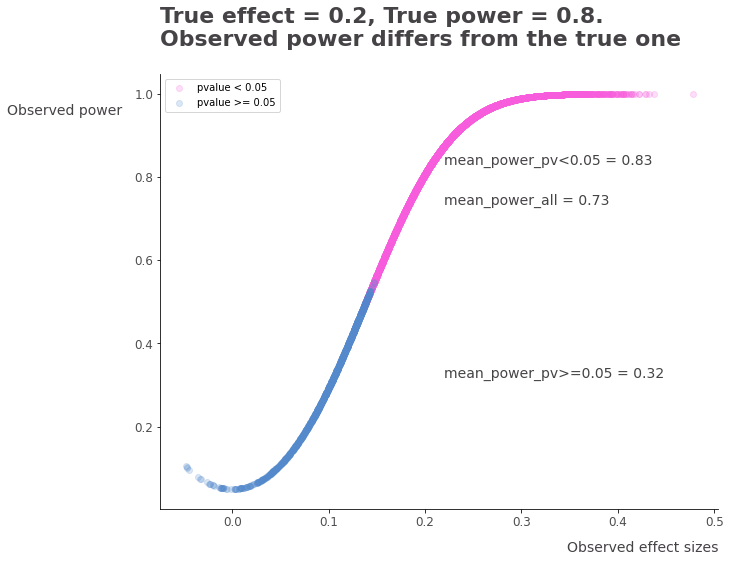

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'pvalue < 0.05':'#f75cdd', 'pvalue >= 0.05': '#548acc'}

# ax.axhline(y=pwg_sign_res, xmin=0.4, xmax=0.55,color='#464346', linestyle='--', alpha=0.5)

for key, gr in df_02.groupby('pv_ind', as_index=False):
    ax.scatter(gr['effects'], gr['obs_power'], label=key, color=colors[key], alpha=0.2)

ax.legend()

for k, v in obs_pwrs_02.items():
    
    ax.text(0.22, v, 
            f'{k} = {round(v, 2)}', 
            horizontalalignment='left', 
            size=14,
            color='#464346')

modify_mpl(ax, 
           title='True effect = 0.2, True power = 0.8.\nObserved power differs from the true one',
           x_title='Observed effect sizes', 
           y_title='Observed power')

## Repeat same things, but set the true effect to 0.05

In [17]:
test_params_005 = {
    'sample_size': 400,
    'effect': 0.05,
    'alpha': 0.05,
}

In [18]:
ex_ante_power = TTestIndPower().solve_power(effect_size=test_params_005['effect'],
                                            nobs1=test_params_005['sample_size'],
                                            ratio=1.0,
                                            alpha=test_params_005['alpha'])


print(f'True power is {ex_ante_power}, which matches the article.')

True power is 0.10880957534352904, which matches the article.


In [19]:
df_005 = simulate_tests(10000, 0.11, **test_params_005)

100%|██████████| 10000/10000 [00:11<00:00, 855.94it/s]


In [20]:
df_005['pv_ind'] = np.where(df_005['pvalues'] < 0.05, 'pvalue < 0.05', 'pvalue >= 0.05')

#### Wrong sign (could not reproduce in the current simulation) and wrong magnitude of the effect
> Figure 2 plots the resulting estimated coefficients and the ex-post power using these estimated effect sizes. While the mean and median estimated b is 0.05, it ranges from -0.19 to +0.32. Note that if we find a statistically significant effect, the estimated treatment effect overstates the true magnitude (what Andrew Gelman calls a type-M error), **and might even be the wrong sign** (that thin wisp of blue dots on the left side of Figure 2 demonstrate what he calls type-S errors – see also this post). Moreover, an author could get an estimated impact of -0.19, and then report their study has ex-post power of 0.78, so claim you should trust their finding that this intervention has actually lowered employment or incomes.

In [21]:
obs_pwrs_005 = get_power_stats(df_005)

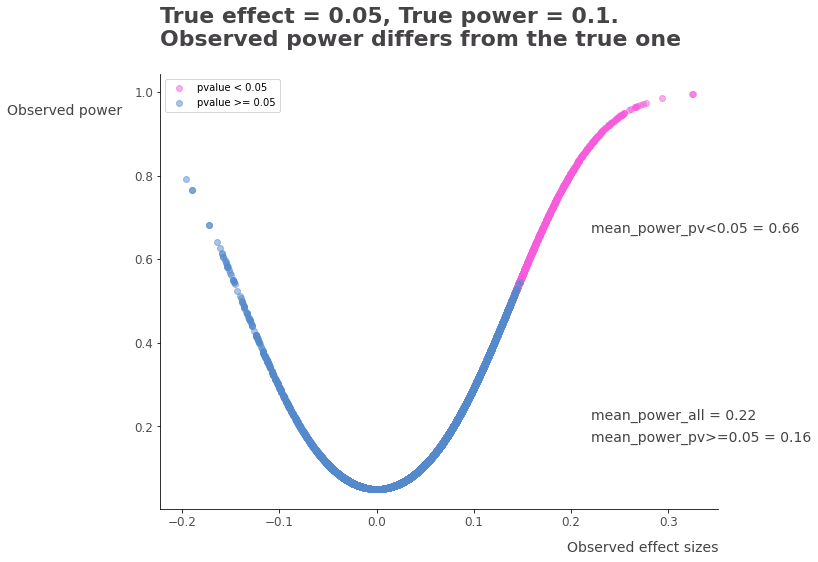

In [22]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'pvalue < 0.05':'#f75cdd', 'pvalue >= 0.05': '#548acc'}

for key, gr in df_005.groupby('pv_ind', as_index=False):
    ax.scatter(gr['effects'], gr['obs_power'], label=key, color=colors[key], alpha=0.5)
    
ax.legend()

for k, v in obs_pwrs_005.items():
    
    ax.text(0.22, v, 
            f'{k} = {round(v, 2)}', 
            horizontalalignment='left', 
            size=14,
            color='#464346')

modify_mpl(ax, 
           title='True effect = 0.05, True power = 0.1.\nObserved power differs from the true one',
           x_title='Observed effect sizes', 
           y_title='Observed power')

## Ex post mde and effect size

>A second solution is to report the ex-post Minimal Detectable Effect (MDE), given your realized sample size and estimated standard error. Since this relies on the estimated, and not true (population, or expected), standard error, there will still be some variation from sample to sample. **But this imprecision will be much less than with the ex-post power, and importantly, will be similar whether your point estimate of the treatment effect ends up being large or small, because it depends only on your (estimated) standard error, not your (more noisily estimated) treatment effect.** Figure 3 illustrates this for the same simulations as in Figure 1 – we see that the estimated MDE clusters closely around the true MDE, and does not depend on whether the study found a significant result or not.

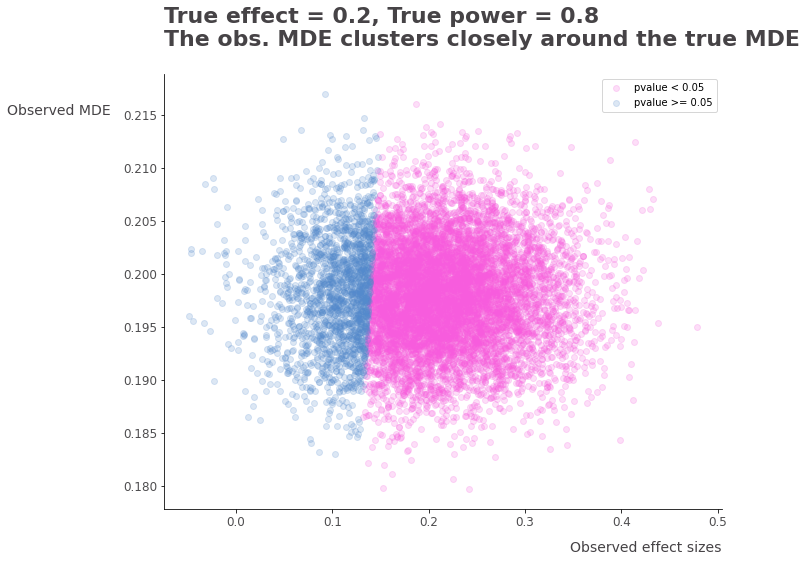

In [23]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'pvalue < 0.05':'#f75cdd', 'pvalue >= 0.05': '#548acc'}

for key, gr in df_02.groupby('pv_ind', as_index=False):
    ax.scatter(gr['effects'], gr['obs_mde'], label=key, color=colors[key], alpha=0.2)
    
ax.legend()


modify_mpl(ax, 
           title='True effect = 0.2, True power = 0.8\nThe obs. MDE clusters closely around the true MDE',
           x_title='Observed effect sizes', 
           y_title='Observed MDE')

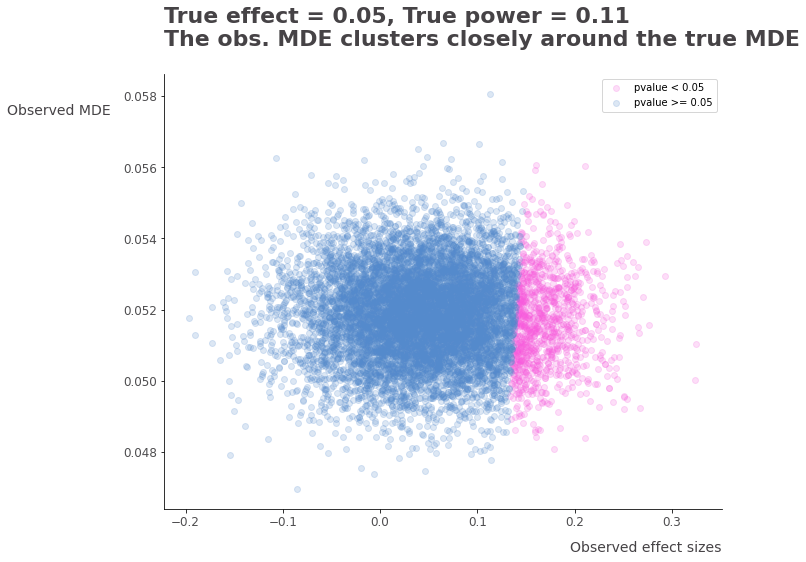

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = {'pvalue < 0.05':'#f75cdd', 'pvalue >= 0.05': '#548acc'}

for key, gr in df_005.groupby('pv_ind', as_index=False):
    ax.scatter(gr['effects'], gr['obs_mde'], label=key, color=colors[key], alpha=0.2)
    
ax.legend()


modify_mpl(ax, 
           title='True effect = 0.05, True power = 0.11\nThe obs. MDE clusters closely around the true MDE',
           x_title='Observed effect sizes', 
           y_title='Observed MDE')